# Multiple Hypothesis Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()  # This helps make our plots look nicer

# These make our figures bigger
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 100



## Multiple testing and the replication crisis

So far, we've looked at false positive rate (FPR) and true positive rate (TPR, or power) when evaluating a single hypothesis test. We saw that when using the traditional null hypothesis significance testing (NHST) framework, we choose a p-value threshold, which is our FPR for each test. If we choose a simple alternative hypothesis, we can compute the TPR by looking at the probability of making a discovery under that alternative hypothesis (i.e., the probability that our test statistic is above our decision threshold under that simple alternative hypothesis).

But in many cases, controlling the false positive rate might not be enough to give us the desired level of errors. To help illustrate this, we'll consider three researchers conducting hypothetical studies of associations between how much margarine people eat and how many books they read in a year:

* Researcher Nat conducts one test, looking at a random sample of all individuals in the US.
* Researcher Stan conducts fifty tests, looking at fifty random samples, one from each state in the US.
* Researcher Colin conducts 3,244 tests, looking at 3,244 random samples, one from each county in the US.

Suppose all three of them use a p-value threshold of 0.02: this means that they should have only a $2\%$ chance of finding false positives. Also, since the premise of the study is somewhat absurd, we can safely assume that *in every test, the null hypothesis is true*: in other words, there is no correlation between margarine consumption and divorce rate. If that's the case, what is the expected number of false positives each one will find?

The number of FPs each researcher finds is a Bernoulli random variable with parameter $p=0.02$ and $n \in \{1, 50, 3244\}$ depending on the researcher. So, the expected number of false positives is $np$:

* Nat's expected number of false positives is $0.05 \times 1 = 0.05$: this is very close to 0.
* Stan's expected number of false positives is $0.05 \times 50 = 2.5$: in other words, even though the null hypothesis is true, Stan should expect to have 2-3 states come up as false positives.
* Colin's expected number of false positives is $0.05 \times 3244 = 162.2$: Colin should expect to have, on average, 162 counties come up as false positives.

These false positives could have serious impacts! Stan's study, if covered poorly in the news, could result in dramatic headlines like "California and Idaho show strong link between margarine consumption and reading: should elementary schools serve more margarine to improve reading rates?" While this example seems somewhat silly since it's obvious that the associations are spurious, this happens often when researchers use poor statistical practices.

A $p$-value threshold of $0.05$ means that we should expect that when the null hypothesis is true, $5\%$ of the time, we'll incorrectly make a discovery. This adds up when doing lots of tests. 

This issue can often come up when researchers are deciding which associations to test. For example, a researcher might be interested in the effect of Vitamin D supplements on overall health. If an initial analysis of the data returns no results, the researcher might try to see if the effects are different for people of different genders. If that turns up no results, the researcher might think that Vitamin D absorption from the sun depends on melanin in skin, so they might look at the effect for all six different [Fitzpatrick skin types](https://en.wikipedia.org/wiki/Fitzpatrick_scale). At this point, in what might be a fairly innocuous sequence of tests, the researcher has already conducted 9 different tests, and the probability of making at least one false positive is$~1 - \left(1-0.05\right)^9 \approx 0.37$. 

### Different approaches to multiple testing

We've seen that when we conduct multiple hypothesis tests at a fixed $p$-value threshold, we can control the FPR of each test, but we don't necessarily control the rate of making errors across multiple tests. In order to address this, we'll define error rates involving all the tests we conduct, and find algorithms that control those error rates. We'll let $m$ be the number of hypothesis tests, and define two error rates:

* The **family-wise error rate (FWER)** is the probability of any one of the $m$ tests resulting in a false positive.
* The **false discovery rate (FDR)** is the expected value of the false discovery proportion (FDP) for the $m$ tests.

We'll explore two algorithms that we can apply to the $p$-values obtained from all $m$ tests: Bonferroni correction, which controls FWER, and the Benjamini-Hochberg procedure, which controls FDR. Here, "controls" means that we're guaranteeing that error rate will be below a certain value we choose. Once we describe the algorithms, we'll discuss the tradeoffs between the two, and how those tradeoffs are related to the inherent properties of the two error rates.

In [2]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('6BrafO72h_w')

In [3]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('ILLMDQkQl9A')

## Randomness, FWER, FDR, and FDP

Up until now, we've focused primarily on the false discovery *proportion* (FDP). From now on, we'll look more at the false discovery *rate* (FDR), so it's important to understand the distinction between the two. Throughout this section, we'll take a frequentist approach, and assume that our data are random (and because our decisions are based on our data, they're random too), and that reality is fixed and unknown.

* The FDP is the value that we obtain for any particular dataset: we obtain data, make a series of decisions, and then the false discovery proportion is based on those particular decisions.
* The FDR is the expectation of the FDP, where the expectation is taken over the randomness in the data. In other words, the FDR is the average FDP, averaged across all possible datasets (and weighted by how likely each one is).
* Similarly, for any particular dataset, we can define the event "at least one false positive happened". This event either occurs or it doesn't for any particular series of decisions. The family-wise error rate (FWER) is the probability of this event occurring for any dataset.

In other words, the false discovery **proportion** is based on any particular dataset, while the false discovery **rate** is the average FDP across all possible datasets.

### Known and Unknown

Throughout this section, we'll discuss FDP, FDR, and FWER as metrics to help us evaluate a decision-making process. But recall that in reality, we only ever observe the data and the decisions we make based on the data: reality is unknown to us. That means that in many real-world scenarios, we can't actually compute the FDP for any particular series of decisions, because it requires us to know when $R=0$ and when $R=1$. 

So if we can't actually compute the FDP, why are we analyzing it?

The key is that the FDR (average FDP) provides a way of evaluating an algorithm. We'll discuss several procedures, and show that on average, they perform well: in other words, if we look at the performance of these procedures averaged over the randomness in the data, we can mathematically show that the FDR or FWER will be below a certain level. For example, we'll look at a procedure called Bonferroni correction and show that if we use it, our FWER, or probability of making a false positive, will be less than a particular threshold that we get to specify.

This process, of first defining algorithms that operate on the observed data to make decisions, then theoretically evaluating those algorithms using metrics that depend on unknown variables, is something we'll see over and over throughout this course.

In [4]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('G9EYjVfLLBU')

## Bonferroni correction

Bonferroni correction is a technique for controlling the FWER. In this context, when we use the term "**controlling** the FWER at level $\alpha$", this just means that we want the FWER to be less than or equal to some value $\alpha$ that we choose.

The procedure itself is very simple: it says that if we want to guarantee that our FWER for $m$ tests will be less than or equal to $\alpha$, then we just need to use a $p$-value threshold of $\alpha/m$ to make a decision for each test. For example, if we want to guarantee an FWER of $0.01$ for $500$ tests, we should use a $p$-value threshold for each test of $0.01 / 5000 = 2 \times 10^{-6}$.

Let's show why this formula works. We'll start by establishing some facts and definitions that we need.

To start, we'll need to use the [union bound](https://en.wikipedia.org/wiki/Boole%27s_inequality), which states that for events $A_1, \ldots, A_m$, that 
$$
P\left(\bigcup_{i=1}^m A_i\right) \leq \sum_{i=1}^m P(A_i).
$$ 

Informally, this says that if we add up the independent probabilities of the events occuring, the result will always be greater than or equal to the probability of the union of those events. Intuitively, this is true because when computing the probability of the union, we have to effectively subtract off the overlap between probabilities.

To use the union bound, we'll define the indicator variables $T_1, \ldots, T_m$, where $T_i$ is the event that test $i$ results in a false positive. The family-wise error rate is the probability that any one of the tests is a false positive: in other words,  $FWER = P(T_1 \cup T_2 \cup T_3 \cdots \cup T_m)$. We know from the previous section that if we use the same $p$-value threshold $\gamma$ for each test, then $P(T_i) = \gamma$. 

Putting it all together, we have:

$$
\begin{align*}
FWER 
    &= P\left(\bigcup_{i=1}^m T_i\right) \\
    &\leq \sum_{i=1}^m P\left(T_i\right) \\
    &= m \gamma
\end{align*}
$$

If we choose our $p$-value threshold for each test $\gamma$ to be equal to $\alpha/m$ (recall that $\alpha$ is our desired FWER), then the right-hand side becomes $\alpha$, and we guarantee that our FWER is less than or equal to $\alpha$.

In [5]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('zwydh-K6Sc4')

## Controlling FDR

### Why control FDR instead of FWER?

Suppose we conduct 1,000,000 tests, and we want to control the FWER at level $0.01$. If we use the Bonferroni procedure, our $p$-value threshold will be $10^{-8}$: we will only make discoveries if the $p$-values are incredibly small! This is because FWER is a very strict criterion. Controlling FWER means we want the probability of making **any** false positives in $m$ tests to be less than or equal to $\alpha$: this requirement gets harder and harder to satisfy the larger $m$ gets. This is why the $p$-value threshold from Bonferroni correction gets smaller as $m$ increases.

Controlling FDR, on the other hand, is much more forgiving of a small number of errors. In our example above, controlling FDR at level $0.01$ means that out of the discoveries we make, we want $1\%$ or fewer of them to be wrong. This is still a much stricter criterion than just controlling FPR as we saw with naive thresholding, but it's easier to satisfy as $m$ grows without imposing such a drastically low $p$-value threshold. Next, we'll see an algorithm that strikes this middle ground.

### The Benjamini-Hochberg Procedure

The Benjamini-Hochberg (often abbreviated to B-H) procedure is slightly more complicated than Bonferroni correction, but it also uses the same $p$-value threshold for all tests. The key is that we use the $p$-values themselves to determine the threshold. Here's how it works, for a desired FDR $\alpha$:

* First, sort the $p$-values, and index them by $k$ (i.e., the first one corresponds to $k=1$, the second one corresponds to $k=2$, and so on, until the last one corresponds to $k=m$)
* For each sorted $p$-value, compare it to the value $\frac{k\alpha}{m}$ (i.e., the smallest p-value gets compared to $\alpha/m$, the second-smallest gets compared to $2\alpha/m$, and so on, until the largest one gets compared to $\alpha$)
* Find the largest sorted $p$-value that's still below its comparison value
* Use that $p$-value as the threshold

In [6]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('w1yZTe7X1JM')

## A Visual Comparison of Naive thresholding, Bonferroni, and Benjamini-Hochberg

Consider the $p$-values we looked at in the last section. We'll add a column `k` that provides the index after being sorted:

In [7]:
p_sorted = pd.read_csv('p_values.csv').sort_values('pvalue')

m = len(p_sorted)  # number of tests
k = np.arange(1, m+1)  # index of each test in sorted order

p_sorted['k'] = k 
p_sorted

,pvalue,is_alternative,k
20,0.000008,1,1
43,0.000109,0,2
56,0.000162,1,3
82,0.000219,1,4
1,0.000436,1,5
...,...,...,...
19,0.952674,0,96
49,0.978843,0,97
13,0.980498,0,98
42,0.982076,0,99


We can visualize the $p$-values in sorted order:

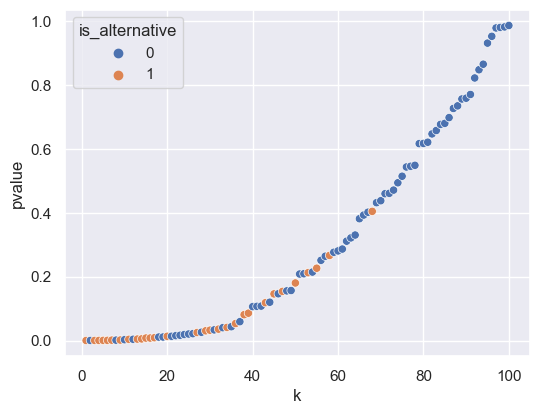

In [8]:
sns.scatterplot(p_sorted, x='k', y='pvalue', hue='is_alternative');

Here, the $x$-axis is $k$, the index, and the $y$-axis represents the $p$-value. We can visualize the results of two techniques:

* If we use a naive $p$-value threshold of 0.05 for all tests, we will obtain an FPR of 0.05. This threshold is the black line below.
* If we use Bonferroni correction and want a FWER of 0.05 (i.e., the probability of making any false positives at all is 0.05), then we should use a $p$-value threshold of $\frac{0.05}{100} = 0.0005$. This threshold is the red dashed line below.

We can see that by using the more conservative Bonferroni threshold (in red), we leave 

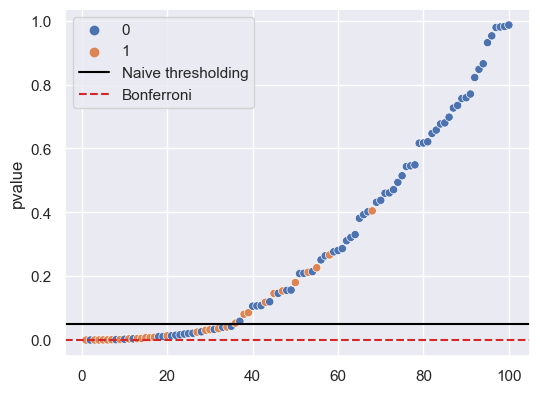

In [9]:
desired_fwer = 0.05
sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative'])
plt.axhline(0.05, label='Naive thresholding', color='black')
plt.axhline(desired_fwer / m, label='Bonferroni', color='tab:red', ls='--')

plt.legend();

In this visualization, how does the Benjamini-Hochberg procedure work? We compare each $p$-value to the comparison value $\frac{k\alpha}{m}$, which in this visualization is a diagonal line. In order to better see what's going on, we'll also zoom in on a narrower range of $p$-values:

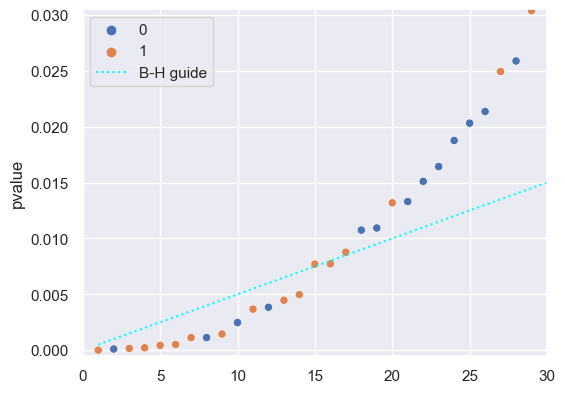

In [10]:
desired_fdr = 0.05
sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative'])
plt.plot(k, k/m * desired_fdr, label='B-H guide', color='cyan', ls=':')
plt.axis([-0.05, 30, -0.0005, 0.0305])
plt.legend();

The Benjamini-Hochberg procedure says to take the largest $p$-value that's below the comparison value $\frac{k\alpha}{m}$: in this case, that's the point at index 16. This becomes our $p$-value threshold, so we choose to reject the null hypothesis for the first 16 $p$-values (after being sorted). The graph below shows all three thresholds:

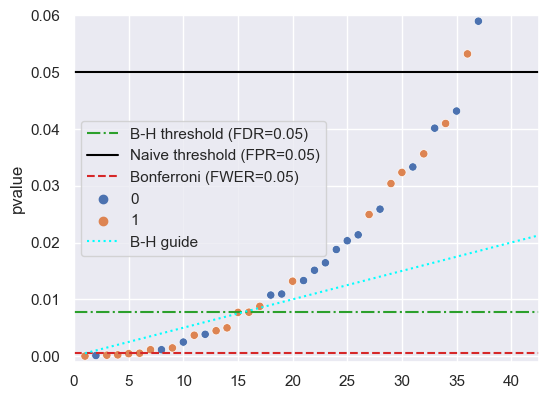

In [11]:
desired_fdr = 0.05
desired_fwer = 0.05

# From visually inspecting the graph above, we saw that the 16th
#  p-value was the last one below the reference value (cyan line)
bh_threshold = p_sorted.loc[p_sorted['k'] == 16, 'pvalue'].iloc[0]

plt.axhline(
    bh_threshold, label=f'B-H threshold (FDR={desired_fdr})', color='tab:green', ls='-.'
)
plt.axhline(
    0.05, label='Naive threshold (FPR=0.05)', color='black', ls='-'
)
plt.axhline(
    desired_fwer / m, label=f'Bonferroni (FWER={desired_fwer})', color='tab:red', ls='--'
)

sns.scatterplot(x=k, y=p_sorted['pvalue'], hue=p_sorted['is_alternative'])
plt.plot(k, k/m * desired_fdr, label='B-H guide', color='cyan', ls=':')
plt.axis([-0.05, 42.5, -0.001, 0.06])
plt.legend();

### Why does Benjamini-Hochberg Control FDR?

*Text coming soon: see video*

In [12]:
# NO CODE

# VIDEO: B-H Proof Sketch
from IPython.display import YouTubeVideo
YouTubeVideo('e10W3lJsBhc')

## Comparing and Contrasting FWER and FDR

Now that we've seen how we might control FWER and FDR, we'll build a better understanding of when each one might be better suited for a particular problem. Recall the definitions:

* Family-wise error rate (FWER) is the probability that any of the $m$ tests is a false positive.
* False discovery rate (FDR) is the expected FDP, or equivalently, the expected fraction of discoveries that are incorrect.

Suppose we conduct 1,000,000 tests ($m=1000000$). 

If we want a FWER of $0.05$, this means that we want the probability of any one of the 1,000,000 tests being a false positive to be 0.05 or less. In order to control this probability, we'll need to be very conservative: after all, even a single false positive will mean that we've failed. In other words, controlling FWER requires us to be very conservative, and use very small $p$-value thresholds. This typically leads to very low power, or true positive rate (TPR), because our $p$-value threshold is so low that we miss many true positives.

On the other hand, if we want a FDR of $0.05$, this just means that out of the discoveries we make in the 1,000,000 tests, on average, we want $95\%$ or more of them to be correct. We can achieve this with a much less conservative threshold. In other words, when we control FDR, we accept some more false positives, and in return we can achieve a higher true positive rate (i.e., do better in the case where $R=1$).

How do these interpretations translate into choosing a rate to control in real-world applications? We'll look at two examples to help illustrate the difference.

* Consider a medical test for a rare condition where the only treatment is a dangerous surgery. In this case, a false positive could subject a patient to unnecessarily undergo the procedure, putting the patient's life needlessly at risk and potentially inducing medical trauma. A false negative, on the other hand, while still potentially harmful due to lack of treatment, may not be as bad. In this case, or any similar case where a false positive is much worse than a false negative, controlling FWER is likely a better choice, since controlling FWER favors false negatives over false positives.

* Consider an online retailer who is interested in conducting many A/B tests to measure whether various website changes improve the chances that shoppers will buy products. In this case, the harm of a false positive is not particularly severe, and we can likely tolerate that $5\%$ of our discoveries could be wrong, especially if it means a better chance of finding changes that increase product purchases.

Note that both of these examples are somewhat ambiguous! In the first example, the cost of a false negative depends strongly on how much the treatment improves the prognosis for patients with the condition, whether follow-on tests exist, and so on. Similarly, in the second example, if the website changes have auxiliary costs (time and money spent by developers to make the changes, changes in user opinion about the website based on the changes, etc.), then this could affect whether we might prefer one over the other.

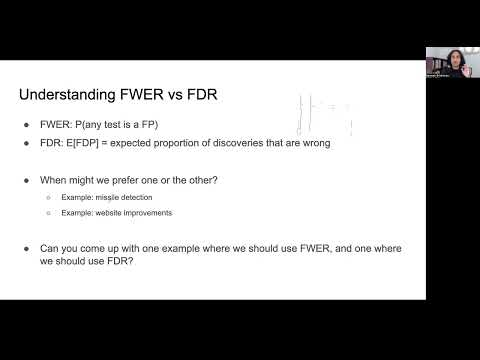

In [13]:
# NO CODE

# VIDEO: B-H Proof Sketch
from IPython.display import YouTubeVideo
YouTubeVideo('hD6zX8zZU_A')